In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.path.abspath(".."))

import gym
import random
import argparse
import numpy as np

import torch
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

from src.agent import AgentA2C
from src.utils import TrajStats, set_seeds
from src.envs_wrappers import SubprocEnvs

In [2]:
def compute_kl(logits_1, logits_2):
    """
    Computes KL divergence between discrete distributions
    """
    
    probs_1 = F.softmax(logits_1, dim=-1)
    kl_components = probs_1 * (F.log_softmax(logits_1, dim=-1) - F.log_softmax(logits_2, dim=-1))
    return torch.mean(torch.sum(kl_components, dim=0))


def get_flat_params(model):
    return torch.cat([param.data.view(-1) for param in model.parameters()])


def set_flat_params(model, flat_params):
    ind_start = 0
    for param in model.parameters():
        ind_end = ind_start + np.prod(param.shape)
        param.data.copy_(flat_params[ind_start : ind_end].view(param.shape))
        ind_start = ind_end
        
        
def get_flat_grads(model, loss):
    """
    Walkaround for computing grads in case loss does not depend on some leafs
    TODO: remove `try` later
    """
    
    grads = []
    #for name, param in model.named_parameters():
    for param in model.parameters():
        try:
            grads.append(torch.autograd.grad(loss, param, create_graph=True)[0])
        except RuntimeError:
            grads.append(torch.zeros_like(param))
            
    return torch.cat([grad.view(-1) for grad in grads])
        
        
def cg(matvec, b, cg_iters=10, residual_tol=1e-10):
    """
    Solves system Ax=b via conjugate gradients method.
    Adapted from John Schulman's code:
    https://github.com/joschu/modular_rl/blob/master/modular_rl/trpo.py
    Arguments:
        matvec        --  matrix-vector product function
        b             --  right-hand side
        cg_iters      --  number of iterations
        residual_tol  --  tolerance
    """
    
    x = torch.zeros(b.size())
    r = b.clone()
    p = b.clone()
    rdotr = torch.dot(r, r)
    
    for i in range(cg_iters):
        Ap = matvec(p)
        alpha = rdotr / torch.dot(p, Ap)
        x += alpha * p
        r -= alpha * Ap
        newrdotr = torch.dot(r, r)
        beta = newrdotr / rdotr
        p = r + beta * p
        rdotr = newrdotr
        if rdotr < residual_tol:
            break
            
    return x

def linesearch(f, x, fullstep, expected_improve_rate, max_backtracks=10, accept_ratio=.1):
    """
    Backtracking linesearch for finding optimal proposed step size.
    Adapted from John Schulman's code:
    https://github.com/joschu/modular_rl/blob/master/modular_rl/trpo.py
    Arguments:
        f                      --  
        x                      --  
        fullstep               --  
        expected_improve_rate  --  
        max_backtracks         --
        accept_ratio           --
    """
    fval = f(x)
    for stepfrac in .5**np.arange(max_backtracks):
        xnew = x + stepfrac*fullstep
        newfval = f(xnew)
        actual_improve = (fval - newfval).data[0]
        expected_improve = expected_improve_rate*stepfrac
        ratio = actual_improve/expected_improve
        if ratio > accept_ratio and actual_improve > 0:
            return True, xnew
    return False, x


def hess_vec_full(vec, model, grads, damping):
    grads_vec = torch.dot(grads, Variable(vec))
    res = get_flat_grads(model, grads_vec).data
    return res + damping * vec


def compute_obj_full(flat_params, agent, tss, gamma, lambda_gae):
    # TODO: rewrite in vector form later and probably without new TrajStats 
    # TODO: and probably rewrite TrajStats, e.g. append to dict, make calc_gae not a method of class
    
    set_flat_params(agent, flat_params)
    
    res = 0
    for ts in tss:
        cur_ts = TrajStats()
        for s, a, r in ts.get_sar():
            logits, value = agent.forward(np.array([s]))
            cur_ts.append(r, F.log_softmax(logits[0], dim=-1)[a], value[0], logits[0], s, a)

        old_logs_pi = ts.get_logs_pi_a()
        advantages = cur_ts.calc_gaes(gamma, lambda_gae)
        logs_pi = cur_ts.get_logs_pi_a()
        res += -(torch.exp(logs_pi - old_logs_pi) * advantages.detach()).sum()
    
    return res / len(tss)

def check_vol():
    return len(list(filter(lambda x: x.volatile, list(agent.parameters())))) == 0

def get_flat_grads_without_try(model, loss):
    """
    temporary, remove it later
    """
    
    grads = []
    for name, param in model.named_parameters():
        grads.append(torch.autograd.grad(loss, param, create_graph=True)[0])
            
    return torch.cat([grad.view(-1) for grad in grads])

In [3]:
cg_damping = 1e-3
max_kl = 1e-1

In [54]:
cr_losses = []

In [55]:
def learn(agent, envs, optimizer, n_timesteps=1e5, gamma=0.99, lambda_gae=0.95, entr_coef=1e-3, log_interval=1e4):
    """
    Optimize networks parameters via interacting with env
    Arguments:
        agent           --  agent to optimize
        envs            --  list of environments to interact with
        n_episodes      --  number of full interaction emulations, int
        lambda_gae      --  mixing coefficient in generalized advantage estimation
        entr_coef       --  entropy loss multiplier, float
        log_interval    --  number of timesteps to print debug info, int
    """

    n_envs = len(envs)
    w_envs = SubprocEnvs(envs)

    agent.train()
    returns = []
    timestep = 0
    timestep_diff = 0
    episode = 0

    while timestep < n_timesteps:
        states = w_envs.reset()
        tss = [TrajStats() for _ in range(n_envs)]

        episode += 1
        while w_envs.has_alive_envs():
            logits, value = agent.forward(states)
            actions = agent.sample_action(logits)

            ind_alive = w_envs.get_indices_alive()
            states_new, rewards, done, _ = w_envs.step(actions)      
            
            for i, i_alive in enumerate(ind_alive):
                tss[i_alive].append(rewards[i], F.log_softmax(logits[i], dim=-1)[actions[i]], value[i], logits[i], states[i], actions[i])
            states = states_new[np.logical_not(done)]

            timestep_diff += len(ind_alive)
            timestep += len(ind_alive)
            if timestep_diff >= log_interval:
                timestep_diff -= log_interval
                print('{} timesteps, av. return: {:.3f}'.format((timestep // log_interval) * log_interval, 
                                                                np.mean(returns[-300:])))
        
        critic_loss = 0
        for ts in tss:
            #entropy += -(aprobs_var * torch.exp(aprobs_var)).sum()
            #critic_loss += 0.5*advantages.pow(2).sum()
            episode_returns = ts.calc_episode_returns(gamma)
            critic_loss += 0.5*(ts.get_values() - episode_returns).pow(2).sum()
            returns.append(ts.calc_return(gamma))

        optimizer.zero_grad()
        (critic_loss / n_envs).backward(retain_graph=True)
        # debug
        cr_losses.append((critic_loss / n_envs).data[0])
        #grads_critic_old = [p.grad for p in agent.parameters()]
        # debug
        
        actor_loss = 0
        for ts in tss:
            advantages = ts.calc_gaes(gamma, lambda_gae)
            logs_pi = ts.get_logs_pi_a()
            actor_loss += -(logs_pi * advantages.detach()).sum()  # minus added in order to ascend
            
        flat_grads = get_flat_grads(agent, actor_loss).data
        if np.allclose(flat_grads.numpy(), 0):
            print('zero gradients, passing')
            continue
        
        kl = 0
        for ts in tss:
            logits = ts.get_logits()
            kl += compute_kl(logits, logits.detach())
        flat_grads_kl = get_flat_grads(agent, kl)

        hess_vec = lambda vec: hess_vec_full(vec, agent, flat_grads_kl, cg_damping)
        
        stepdir = cg(hess_vec, -flat_grads)
        shs = 0.5 * torch.dot(stepdir, hess_vec(stepdir))
        lm = np.sqrt(shs / max_kl)
        proposed_step = stepdir / lm
        neggdotstepdir = torch.dot(-flat_grads, stepdir)
        
        compute_obj = lambda flat_params: compute_obj_full(flat_params, agent, tss, gamma, lambda_gae)
            
        params_prev = get_flat_params(agent)
        success, params_new = linesearch(compute_obj, params_prev, proposed_step, neggdotstepdir / lm)
        set_flat_params(agent, params_new)
        
        # debug
        #grads_critic = [p.grad for p in agent.parameters()]
        #assert len(grads_critic_old) == len(grads_critic)
        #print(([(grads_critic_old[i] == grads_critic[i]) for i in range(len(grads_critic))]))
        # debug
        optimizer.step()
        
    w_envs.close()

In [56]:
cr_losses = []

In [57]:
n_timesteps = 50000
gamma = 0.99
log_interval = 5000
batch_size = 32

env = 'CartPole-v1'
#env = 'FrozenLake-v0'
envs = [gym.make(env) for _ in range(batch_size)]
set_seeds(envs, 417, False)

agent = AgentA2C(envs[0].observation_space, envs[0].action_space)
optimizer = optim.Adam(agent.parameters())

learn(agent, envs, optimizer, n_timesteps=n_timesteps, gamma=gamma, log_interval=log_interval)

5000 timesteps, av. return: 18.391
10000 timesteps, av. return: 19.651
15000 timesteps, av. return: 18.456
20000 timesteps, av. return: 19.216
25000 timesteps, av. return: 20.163
30000 timesteps, av. return: 19.106
35000 timesteps, av. return: 19.106
40000 timesteps, av. return: 19.182
45000 timesteps, av. return: 18.955
50000 timesteps, av. return: 19.007


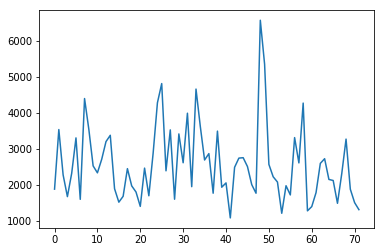

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(cr_losses)

In [ ]:
n_timesteps = 100000
gamma = 0.99
log_interval = 5000
batch_size = 32

env = 'CartPole-v1'
#env = 'FrozenLake-v0'
envs = [gym.make(env) for _ in range(batch_size)]
set_seeds(envs, 417, False)

agent = AgentA2C(envs[0].observation_space, envs[0].action_space)
optimizer = optim.Adam(agent.parameters())

learn(agent, envs, optimizer, n_timesteps=n_timesteps, gamma=gamma, log_interval=log_interval)

In [ ]:
n_timesteps = 100000
gamma = 0.99
log_interval = 5000
batch_size = 32

#env = 'CartPole-v1'
env = 'FrozenLake-v0'
envs = [gym.make(env) for _ in range(batch_size)]
set_seeds(envs, 417, False)

agent = AgentA2C(envs[0].observation_space, envs[0].action_space)
optimizer = optim.Adam(agent.parameters())

learn(agent, envs, optimizer, n_timesteps=n_timesteps, gamma=gamma, log_interval=log_interval)